# Introduction

In this chapter, we dive into artificial neural networks, one of the main drivers of artificial intelligence. 

Neural networks are around since many decades. (Maybe) the first such model was built by Marvin Minsky in 1951. He called his algorithm SNARC ("stochastic neural-analog reinforcement calculator"). Since then, neural networks have gone through several stages of development. One of the milestones was the idea of Paul J. Werbos in 1974 [1] to efficiently calculate gradients in the optimization algorithm by an approach called "backpropagation". Another milestone was the use of GPUs  (graphics processing units) to greatly reduce calculation time.

Artificial neural nets are extremely versatile and powerful. They can be used to

1. fit simple models like GLMs,
2. learn interactions and non-linear effects in an automatic way (like tree-based methods),
3. optimize general loss functions,
4. fit data much larger than RAM (e.g. images),
5. learn "online" (update the model with additional data),
6. fit multiple response variables at the same time,
7. model input of dimension higher than two (e.g. images, videos),
8. model input of *different* input dimensions (e.g. text *and* images),
9. fit data with sequential structure in both in- and output (e.g. a text translator),
10. model data with spatial structure (images),
11. fit models with many millions of parameters,
12. do non-linear dimension reduction.

In this chapter, we will mainly deal with the first three aspects. Since a lot of new terms are being used, a small glossary can be found in Section "Neural Network Slang".

# Understanding Neural Nets

To learn how and why neural networks work, we will go through three steps - each illustrated on the diamonds data:

- Step 1: Linear regression as neural net
- Step 2: Hidden layers
- Step 3: Activation functions

After this, we will be ready to build more complex models.

## Step 1: Linear regression as neural net

Let us revisit the simple linear regression
$$
  E(\text{price}) = \alpha + \beta \cdot \text{carat}
$$
calculated on the full diamonds data. In Chapter 1 we have found the solution $\hat\alpha = -2256.36$ and $\hat \beta = 7756.43$ by ordinary least-squares.

Above situation can be viewed as a neural network with

- an input layer with two nodes (`carat` and the intercept called "bias unit" with value 1),
- a "fully connected" (= "dense") output layer with one node (`price`). Fully connected means that each node of a layer is a linear function of all node values of the previous layer. Each linear function has parameters or *weights* to be estimated, in our simple case just $\alpha$ and $\beta$.

Visualized as a graph, the situation looks as follows.

<img src="../figs/nn_simple_linear.PNG" width="70%">

*Part of the figures were done with this cool [webtool](http://alexlenail.me/NN-SVG/index.html).*

To gain confidence in neural nets, we first show that parameters estimated by a neural network are quite similar to the ones learned by linear least-squares. To do so, we will use Google's [TensorFlow](https://www.tensorflow.org/) with its convenient (functional) [Keras](https://keras.io/) interface. 

### Example: simple linear regression

In [1]:
# Chapter imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.metrics import RootMeanSquaredError
from utils import KerasRegressor, ColumnSplitter  # utils.py


diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")

In [150]:
# Define model

# Input layer: we have 1 covariate
inputs = keras.Input(shape=1)

# Output layer densely connected to the input layer
outputs = layers.Dense(1)(inputs)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 dense_78 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
# Compile model, i.e., calculate derivatives of architecture
model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1),
    metrics=[RootMeanSquaredError()],
)

In [152]:
# Fit model - naive without validation
history = model.fit(
    x=diamonds["carat"],
    y=diamonds["price"],
    epochs=30,
    batch_size=100,
    verbose=0,
)

# Fitted coefficients
print("Fitted coefficients with neural net:", model.get_weights())

Fitted coefficients with neural net: [array([[7718.0703]], dtype=float32), array([-2222.4849], dtype=float32)]


In [153]:
# Compare with linear regression
ols = smf.ols(formula="price ~ carat", data=diamonds).fit()
print("Fitted with OLS:", ols.params, sep="\n")

Fitted with OLS:
Intercept   -2256.360580
carat        7756.425618
dtype: float64


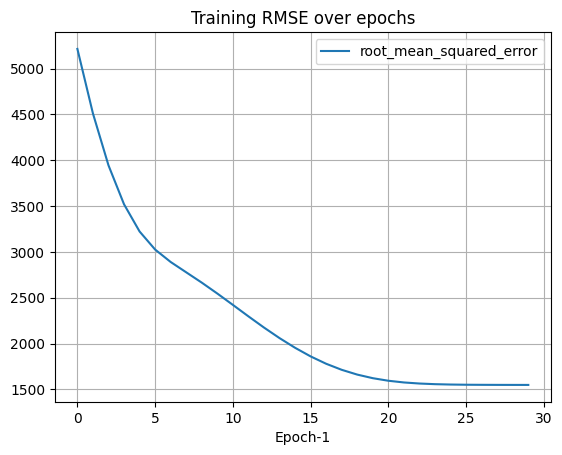

In [154]:
# Plot training RMSE over epochs
_ = (
    pd.DataFrame(history.history)
    .filter(like="root")
    .plot(xlabel="Epoch-1", grid=True, title="Training RMSE over epochs")
)

1/1 [==============================] - 0s 87ms/step


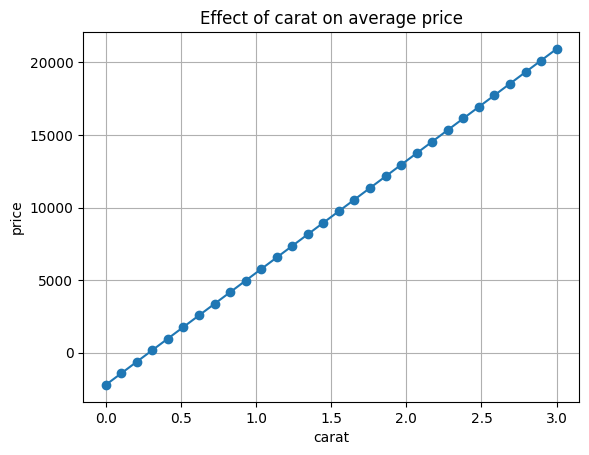

In [155]:
# Effect of carat on average price
def plot_carat_effect(model):
    """Effect of carat in univariable model"""
    carat = np.linspace(0, 3, 30)
    plt.plot(carat, model.predict(carat), marker="o")
    plt.gca().set(
        title="Effect of carat on average price", ylabel="price", xlabel="carat"
    )
    plt.grid()


plot_carat_effect(model)

**Comment:** The solution of the simple neural network is indeed quite similar to the OLS solution. 

### The optimization algorithm

Neural nets are typically fitted by **mini-batch gradient descent**, using **backpropagation** to efficiently calculate gradients. It works as follows:

1. Initiate the parameters with random values. 
2. Forward step: Use the parameters to predict all observations of a *batch*. A batch is a randomly selected subset of the full data set.
3. Backpropagation step: Change the parameters in the right direction, making the average loss $Q$ (e.g., the MSE) of the current batch smaller. This involves calculating derivatives ("gradients") of $Q$ with respect to all parameters. Backpropagation does so in a layer-per-layer fashion, making heavy use of the chain rule. 
4. Repeat Steps 2-3 until each observation appeared in a batch. This is called an *epoch*.
5. Repeat Step 4 for multiple epochs until the parameter estimates stabilize or validation performance stops improving.

Gradient descent on batches of size 1 is called "stochastic gradient descent" (SGD).

## Step 2: Hidden layers

Our first neural network above consisted of only an input layer and an output layer. By adding one or more *hidden* layers between in- and output, the network gains additional parameters, and thus more flexibility. The nodes of a hidden layer can be viewed as latent variables, representing the original covariates. The nodes of a hidden layer are sometimes called *encoding*. The closer a layer is to the output, the better its nodes are suitable to predict the response variable. In this way, a neural network finds the right transformations and interactions of its covariates in an automatic way. The only ingredients are a large data set and a flexible enough network "architecture" (number of layers, nodes per layer). 

Neural nets with more than one hidden layer are called "deep neural nets".

We will now add a hidden layer with five nodes $v_1, \dots, v_5$ to our simple linear regression network. The architecture looks as follows:

<img src="../figs/nn_1_hidden.PNG" width="70%">

This network has 16 parameters. How much better than our simple network with just two parameters will it be?

### Example: hidden layer

The following code is almost identical to the last one up, except that there is a hidden layer between input and output layer.

1/1 [==============================] - 0s 72ms/step


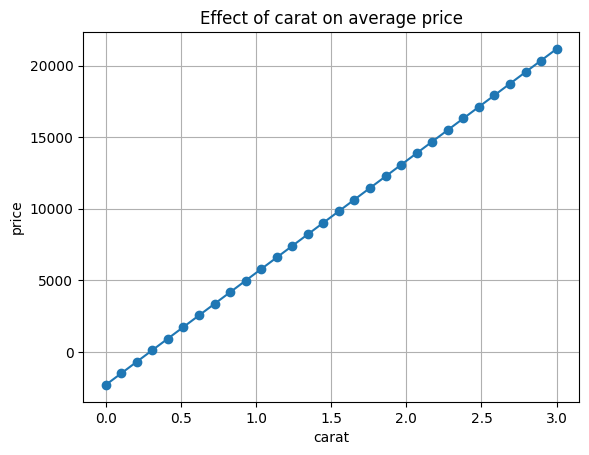

In [156]:
inputs = keras.Input(shape=1)
hidden = layers.Dense(5)(inputs)  # new line of code!
outputs = layers.Dense(1)(hidden)

model = keras.Model(inputs=inputs, outputs=outputs)
# model.summary()

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1),
    metrics=[RootMeanSquaredError()],
)
model.fit(
    x=diamonds["carat"],
    y=diamonds["price"],
    epochs=30,
    batch_size=100,
    verbose=0,
)

plot_carat_effect(model)

**Comment:** Oops, it seems as if the extra hidden layer had no effect. The reason is that a linear function of a linear function is still a linear function. Adding the hidden layer did not really change the capabilities of the model. It just added a lot of unnecessary parameters.

## Step 3: Activation functions

The missing magic component is the so called [*activation* function](https://en.wikipedia.org/wiki/Activation_function) $\sigma$ after each layer, which transforms the values of the nodes. So far, we have implicitly used "linear activations", which - in neural network slang - is just the identity function. 

Applying *non-linear* activation functions after hidden layers have the purpose to introduce non-linear and interaction effects. Typical such functions are

- the hyperbolic tangent $\sigma(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ ("S"-shaped function that maps real values to $[-1, 1]$),
- the standard logistic function ("sigmoid") $\sigma(x) = 1 / (1 + e^{-x})$ ("S"-shaped function that maps real values to $[0, 1]$, shifted and scaled hyperbolic tangent),
- the **re**ctangular **l**inear **u**nit "ReLU" $\sigma(x) = \text{max}(0, x)$ that sets negative values to 0.

Activation functions applied to the *output* layer have a different purpose, namely the same as the inverse of the link function of a corresponding GLM. It maps predictions to the scale of the response: 

- identity/"linear" activation $\rightarrow$ usual regression
- logistic activation $\rightarrow$ binary logistic regression (one probability)
- softmax activation $\rightarrow$ multinomial logistic regression (one probability per class)
- exponential activation $\rightarrow$ log-linear regression as with Poisson or Gamma regression

Let us add a hyperbolic tangent activation function ($\sigma$) after the hidden layer of our simple example.

<img src="../figs/nn_activation.PNG" width="80%">

### Example: activation functions

Again, the code is very similar to the last one, with the exception of using a hyperbolic tangent activation after the hidden layer (and different learning rate and number of epochs).

1/1 [==============================] - 0s 67ms/step


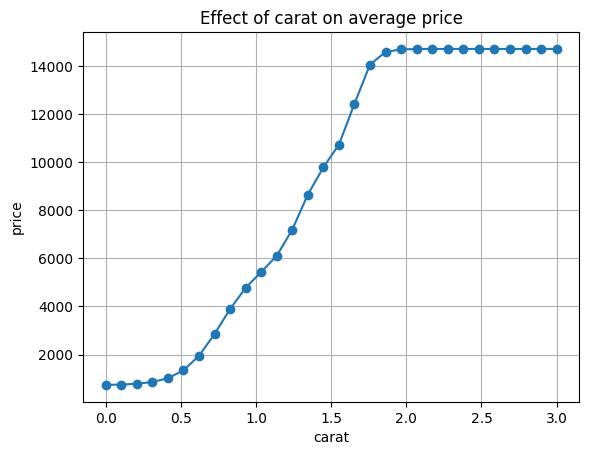

In [157]:
inputs = keras.Input(shape=1)
hidden = layers.Dense(5, activation="tanh")(inputs)
outputs = layers.Dense(1, activation="linear")(hidden)

model = keras.Model(inputs=inputs, outputs=outputs)
# model.summary()

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.2),
    metrics=[RootMeanSquaredError()],
)

model.fit(
    x=diamonds["carat"],
    y=diamonds["price"],
    epochs=50,
    batch_size=100,
    verbose=0,
)

plot_carat_effect(model)

**Comment:** Adding the non-linear activation after the hidden layer has changed the model. The effect of carat is now representing the association between carat and price by a non-linear function.

# Practical Considerations

## Validation and tuning of main parameters

So far, we have naively fitted the neural networks without splitting the data for test and validation. Don't do this! Usually, one sets a small test dataset (e.g. 10% of rows) aside to assess the final model performance and use simple (or cross-)validation for model tuning.

In order to choose the main tuning parameters, namely

- network architecture,
- activation functions,
- learning rate, 
- batch size, and
- number of epochs, 

one often uses simple validation because cross-validation takes too much time.

## Missing values

A neural net does not accept missing values in the input. They need to be filled, e.g., by a typical value or a value below the minimum.

## Input standardization

Gradient descent starts by random initialization of parameters. This step is optimized for standardized input. Standardization has to be done manually by either

- min/max scale the values of each input to the range -1 to 1,
- standard scale the values of each input to mean 0 and standard deviation 1, or
- use relative ranks.

Note that the scaling transformation is calculated on the training data and then applied to the validation and test data. This usually requires a couple of lines of code.

## Categorical input

There are three common ways to represent categorical input variables in a neural network. 

1. Binary and ordinal categoricals are best represented by integers and then treated as numeric.
2. Unordered categoricals are either one-hot-encoded (i.e., each category is represented by a binary variable) or 
3. they are represented by a (categorical) embedding. To do so, the categories are integer encoded and then condensed by a special *embedding layer* to a few (usually 1 or 2) dense features. This requires a more complex network architecture but saves memory and preprocessing. This approach is heavily used when the input consists of words (which is a categorical variable with thousands of levels - one level per word).

For Option 2, input standardization is not required, for Option 3 it *must* not be applied as the embedding layer expects integers.

## Callbacks

Sometimes, we want to take actions during training, such as

- stop training when validation performance starts worsening,
- reduce the learning rate when the optimization is stuck in a "plateau", or
- save the network weights between epochs.

Such monitoring tasks are called *callbacks*. We will see them in the example below.

## Types of layers

So far, we have encountered only dense (= fully connected) layers and activation layers. Here some further types:

- Embedding layers to represent integer encoded categoricals.
- Dropout layers to add regularization.
- Convolutional and pooling layers for image data.
- Recurrent layers (long-short-term memory LSTM, gated recurrent unit GRU) for sequence data.
- Concatenation layers to combine different branches of the network (like in a directed graph).
- Flatten layers to bring higher dimensional layers to dimension 1 (relevant, e.g., for embeddings, image and text data).

## Optimizer

Pure gradient descent is rarely applied without tweaks because it tends to be stuck in local minima, especially for complex networks with non-convex objective surfaces. Modern variants are "adam", "nadam" and "RMSProp". These optimizers work usually out-of-the-box, except for the learning rate, which has to be manually chosen.

## Custom losses and evaluation metrics

Frameworks like Keras/TensorFlow offer many predefined loss functions and evaluation metrics. Choosing them is a crucial step, just as with tree boosting.
Using TensorFlow's backend functions, one can define own metrics and loss functions (see exercises).

## Overfitting and regularization

As with linear models, a model with too many parameters will overfit in an undesired way. With about 50 to 100 observations per parameter, overfitting is usually unproblematic. (For image and text data, different rules apply). Besides using less parameters, the main options to reduce overfitting are the following:

- pull the parameters of a layer slightly towards zero by applying L1 and/or L2 penalties to the parameters,
- add dropout layers. A dropout layer randomly sets some of the node values of the previous layer to 0, switching them off. This is an elegant way to fight overfitting and is related to bagging.

## Choosing the architecture

How many layers and number of nodes per layer to select? For tabular data, using 1-3 hidden layers is usually enough. If we start with $m$ input variables, the number of nodes in the first hidden layer is usually higher than $m$ and reduces for later layers. There should not be a "representational bottleneck", i.e., an early hidden layer with too few parameters. 

The number of parameters should not be too high compared to the number of rows, see "Overfitting and regularization" above. 

## Interpretation

Variable importance of covariates in neural networks can be assessed by permutation importance (how much performance is lost when shuffling column X?) or SHAP importance. Covariate effects can be investigated, e.g., by partial dependence plots or SHAP dependence plots.

# Example: diamonds

We will now fit a neural net with two hidden layers (30 and 15 nodes) and a total of 631 parameters to model diamond prices. Learning rate, activation functions, and batch size were manually chosen by simple validation. The number of epochs is automatically being chosen by an early stopping callback.

<img src="../figs/nn_2_hidden.PNG" width="40%">

In [158]:
# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Data preprocessing pipeline
ord_vars = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("numeric", "passthrough", ["carat"]),
            ("ordinal", OrdinalEncoder(categories=ord_levels), ord_vars),
        ],
        verbose_feature_names_out=False,
    ),
    StandardScaler(),
).set_output(transform="pandas")

X_train = preprocessor.fit_transform(df_train)
X_test = preprocessor.transform(df_test)
X_test[0:2]  # Check

,carat,cut,color,clarity
2014,-0.185796,0.810577,-0.353796,-1.785901
21245,1.480427,1.706622,0.821629,0.640050


In [159]:
# Define model

# Input layer: we have 4 covariates
inputs = keras.Input(shape=4)

# Two hidden layers with contracting number of nodes
x = layers.Dense(30, activation="relu")(inputs)
x = layers.Dense(15, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)

keras_model = keras.Model(inputs=inputs, outputs=outputs)
keras_model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_83 (Dense)            (None, 30)                150       
                                                                 
 dense_84 (Dense)            (None, 15)                465       
                                                                 
 dense_85 (Dense)            (None, 1)                 16        
                                                                 
Total params: 631 (2.46 KB)
Trainable params: 631 (2.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [160]:
# Compile and fit model
keras_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=0.5),
    metrics=[RootMeanSquaredError()],
)

# Callbacks
cb = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]

# Fit model
tf.random.set_seed(4)

history = keras_model.fit(
    x=X_train,
    y=y_train,
    epochs=200,
    batch_size=500,
    validation_split=0.2,
    callbacks=cb,
    verbose=0,
)

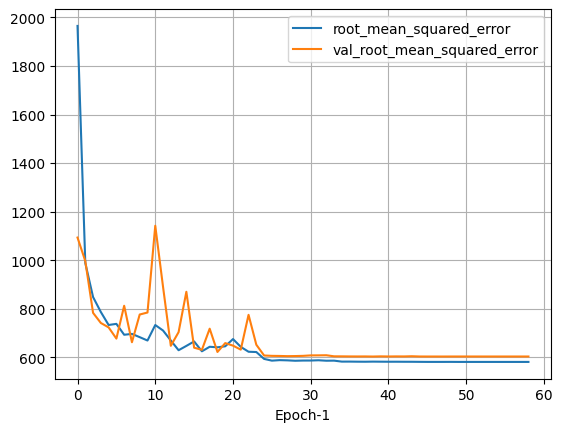

In [161]:
# Plot RMSE over epochs
_ = pd.DataFrame(history.history).filter(like="root").plot(xlabel="Epoch-1", grid=True)

In [162]:
# Interpretation

# Performance on test data
dummy = DummyRegressor().fit(X_train, y_train)
mse_0, mse = (
    mean_squared_error(y_test, mod.predict(X_test)) for mod in (dummy, keras_model)
)
print(f"Test RMSE: {np.sqrt(mse):.3f}")
print(f"Test R-squared: {(mse_0 - mse) / mse_0:.2%}")

338/338 [==============================] - 1s 1ms/step
Test RMSE: 587.068
Test R-squared: 97.85%


338/338 [==============================] - 0s 1ms/step


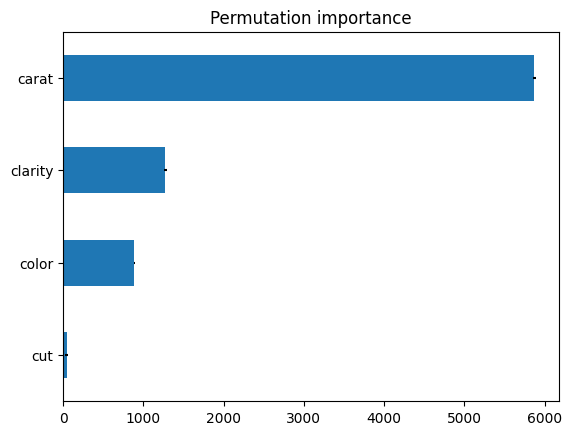

In [163]:
features = X_test.columns

imp = permutation_importance(
    keras_model,
    X=X_test[features],
    y=y_test,
    n_repeats=4,
    random_state=46,
    scoring="neg_root_mean_squared_error",
)

# Plot with standard deviations
_ = (
    pd.Series(imp["importances_mean"], index=features)
    .sort_values()
    .plot(kind="barh", xerr=imp["importances_std"], title="Permutation importance")
)

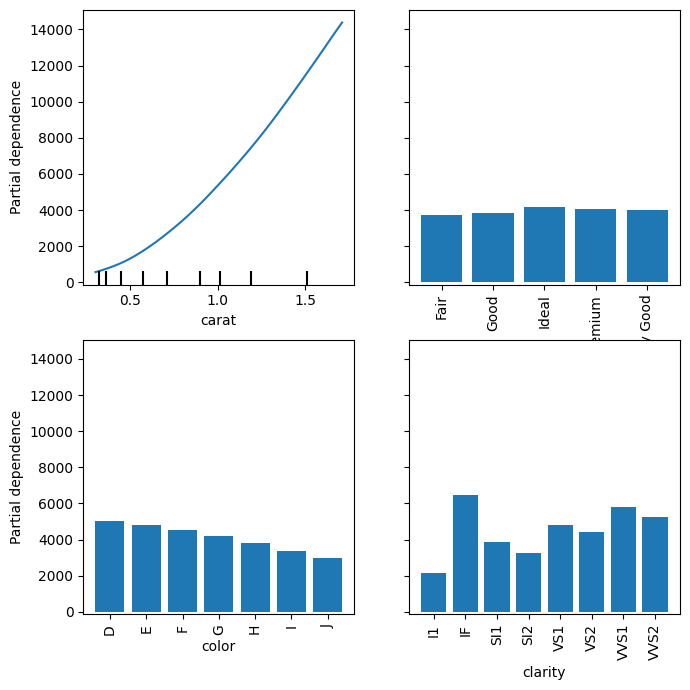

In [164]:
# To plot original feature values, we build a Scikit-Learn-like pipeline
model = KerasRegressor(make_pipeline(preprocessor, keras_model))

fig, axes = plt.subplots(figsize=(7, 7))

PartialDependenceDisplay.from_estimator(
    model,
    features=features,
    categorical_features=ord_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

**Comment:** Performance is lower than of the tree-based models. This might partly be a consequence of effects being smoother, but also because the model has not been refitted on the full training data for simplicity (20% of the training rows are used for validation).

# Example: Embeddings

Representing categorical input variables through embedding layers is extremely useful in practice. We will end this chapter with an example on how to do it with the claims data. This example also shows how flexible neural network structures are.

In [165]:
# Load and inspect data
car = pd.read_parquet("dataCar.parquet")
car.head()

,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat
0,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2
1,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4
2,3.26,0.569473,0,0,0.0,UTE,2,F,E,2
3,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2
4,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2


In [166]:
# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=5684, stratify=car["clm"]
)

# Preprocessing: The logic is to provide X as a dict to fit(). One key contains
# scaled dense features, the other the integer encoded values of the embedding feature
num_vars = ["veh_value", "veh_age", "agecat"]
ord_vars = ["gender", "area"]
dense_vars = num_vars + ord_vars

In [167]:
trafo = ColumnTransformer(
    transformers=[
        ("numeric", StandardScaler(), num_vars),
        ("ordinal", make_pipeline(OrdinalEncoder(), StandardScaler()), ord_vars),
        ("veh_body", OrdinalEncoder(), ["veh_body"]),  # no scaling!
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

preprocessor = Pipeline(
    steps = [
        ("transform", trafo),
        ("split", ColumnSplitter({"dense1": dense_vars, "veh_body": ["veh_body"]})),
    ]
)

# Test pipeline -> dict with scaled dense features and integer encoded veh_body
X_train = preprocessor.fit_transform(df_train)
preprocessor.transform(df_test.head(2))

{'dense1':        veh_value   veh_age    agecat    gender      area
 35491   0.630668 -1.568965  1.063021 -0.869824 -0.542314
 65442  -0.672406  0.304049 -1.039166 -0.869824 -1.238716,
 'veh_body':        veh_body
 35491      10.0
 65442       3.0}

In [168]:
# Define model

# Inputs
input_dense = keras.Input(shape=len(dense_vars), name="dense1")
input_veh_body = keras.Input(shape=1, name="veh_body")

# Embedding of veh_body
m_bodies = df_train["veh_body"].nunique()
emb = layers.Embedding(input_dim=m_bodies, output_dim=1)(input_veh_body)
emb = layers.Flatten()(emb)

# Combine dense input and embedding and connect to output
x = layers.Concatenate()([input_dense, emb])
x = layers.Dense(30, activation="relu")(x)
x = layers.Dense(5, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Input
inputs = {"dense1": input_dense, "veh_body": input_veh_body}

# Create model
keras_model = keras.Model(inputs=inputs, outputs=outputs)
keras_model.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 veh_body (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 1, 1)                 13        ['veh_body[0][0]']            
                                                                                                  
 dense1 (InputLayer)         [(None, 5)]                  0         []                            
                                                                                                  
 flatten_18 (Flatten)        (None, 1)                    0         ['embedding_18[0][0]']        
                                                                                           

In [169]:
# Compile and fit model
keras_model.compile(
    loss="binary_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
)

cb = [
    keras.callbacks.EarlyStopping(patience=20),
    keras.callbacks.ReduceLROnPlateau(patience=5),
]

tf.random.set_seed(443)

history = keras_model.fit(
    x=X_train,
    y=y_train,
    epochs=1000,
    batch_size=200,
    validation_split=0.2,
    callbacks=cb,
    verbose=0,
)

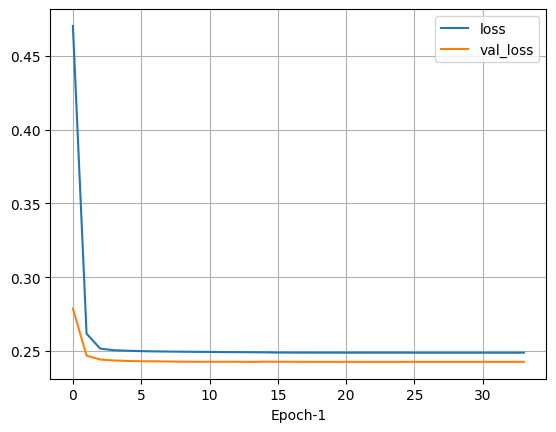

In [170]:
# Plot average log loss over epochs
_ = pd.DataFrame(history.history).filter(like="loss").plot(xlabel="Epoch-1", grid=True)

In [171]:
# Interpretation: we build a clean Scikit-Learn pipeline
model = KerasRegressor(make_pipeline(preprocessor, keras_model))
model.predict(df_test.head())  
# Note: we have just probabilities of the positive class

array([0.0590177 , 0.07105293, 0.05931867, 0.07135783, 0.05981461],
      dtype=float32)

In [172]:
# Performance: Scikit-Learn's log_loss() works properly if only one probability pops out
dummy = DummyRegressor().fit(df_train, y_train)

logloss_0, logloss = (
    log_loss(y_test, mod.predict(df_test)) for mod in (dummy, model)
)

print(f"Average log loss: {logloss: .3f}")
print(f"Rel imp in average log loss: {(logloss_0 - logloss) / logloss_0: .3%}")

Average log loss:  0.249
Rel imp in average log loss:  0.073%


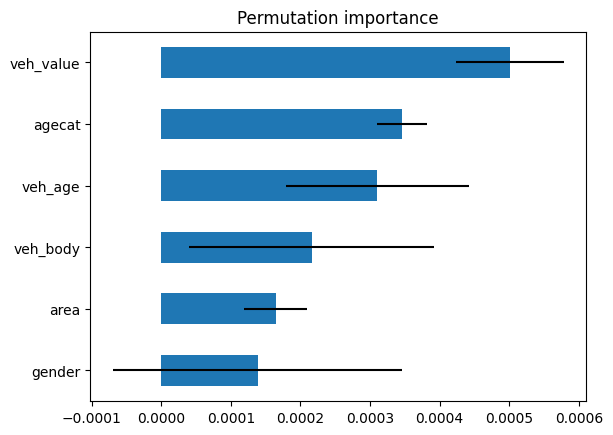

In [173]:
# Permutation importance on test data
features = dense_vars + ["veh_body"]

model.predict_proba = model.predict  # Scikit-Learn decides for predict_proba()...
imp = permutation_importance(
    model,
    X=df_test[features],
    y=y_test,
    n_repeats=4,
    random_state=46,
    scoring="neg_log_loss",
)

# Plot with standard deviations
_ = (
    pd.Series(imp["importances_mean"], index=features)
    .sort_values()
    .plot(kind="barh", xerr=imp["importances_std"], title="Permutation importance")
)

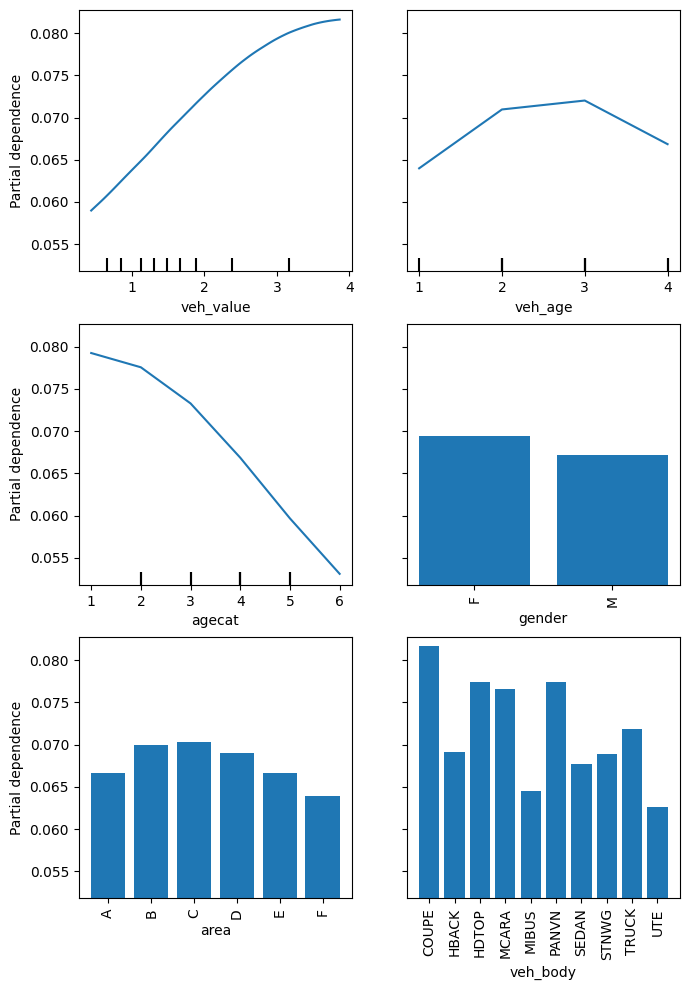

In [174]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=features,
    categorical_features=ord_vars + ["veh_body"],
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

# Exercises

1. Fit diamond prices by minimizing Gamma deviance with log-link (-> exponential output activation), using the custom loss function defined below. Tune the model by simple validation and evaluate it on a test dataset. Interpret the final model. Hints: I used a smaller learning rate and had to replace the "relu" activations by "tanh". Furthermore, the response needed to be transformed from int to float.

```py
from tensorflow.keras import backend as K

def loss_gamma(y_true, y_pred):
  return -K.log(y_true / y_pred) + y_true / y_pred
```

2. Study either the optional claims data example or build your own neural net, predicting claim yes/no. For simplicity, you can represent the categorical feature `veh_body` by integers.

# Neural Network Slang

Here, we summarize some of the neural network slang.

- Activation function: The transformation applied to the node values.
- Architecture: The layout of layers and nodes.
- Backpropagation: An efficient way to calculate gradients.
- Batch: A couple of data rows used for one mini-batch gradient descent step.
- Callback: An action during training (save weights, reduce learning rate, stop training, ...).
- Epoch: The process of updating the network weights by gradient descent until each observation in the training set was used once.
- Embedding: A numeric representation of categorical input as learned by the neural net.
- Encoding: The values of latent variables of a hidden layer, usually the last.
- Gradient descent: The basic optimization algorithm of neural networks.
- Keras: User-friendly wrapper of TensorFlow.
- Layer: Main organizational unit of a neural network.
- Learning rate: Controls the step size of gradient descent, i.e., how aggressive the network learns.
- Node: Nodes on the input layer are the covariates, nodes on the output layer the response(s) and nodes on a hidden layer are latent variables representing the covariates for the task to predict the response.
- Optimizer: The specific variant of gradient descent.
- PyTorch: An important implementation of neural networks.
- Stochastic gradient descent (SGD): Mini-batch gradient descent with batches of size 1.
- TensorFlow: An important implementation of neural networks.
- Weights: The parameters of a neural net.

# Chapter Summary

In this chapter, we have glimpsed into the world of neural networks. Step by step we have learned how a neural network works. We have used Keras and TensorFlow to build models brick by brick.

# Closing Remarks

During this lecture, we have met many ML algorithms and principles. To get used to them, the best approach is practicing. [Kaggle](kaggle.com) is a great place to do so and learn from the best. 

A summary and comparison of the algorithms can be found on [github](https://github.com/mayer79/ML_Algorithm_Comparison). Here a screenshot as per Sept. 7, 2020: 
![](../figs/comparison_ML.PNG)

As a final task and motivation, try out my *Analysis scheme X*. It can be applied very frequently and works as follows:

1. Take a property $T(Y)$ of key interest, e.g., the churn rate, a claims frequency, or a loss ratio. Calculate its estimate on the full dataset.
2. Do a descriptive analysis of $T(Y \mid X_j)$ for a couple of important covariates $X_1, \dots, X_p$ in order to study the association between $Y$ and each of the $X_j$ separately.
3. Complement Step 2 by running a well-built ML model $T(Y \mid X_1, \dots, X_p) = f(X_1, \dots, X_p)$, using a clean validation strategy.
    - Study model performance.
    - Study variable importance and use it to sort the results of Step 2. Which of the associations are very strong/weak?
    - For each $X_j$, study its partial dependence (or SHAP dependence) plot. They will accompany the bivariate view of Step 2 with a multivariate one, taking into account the effects from the other covariates.
    
What additional insights did you get from Step 3?

# Chapter References

[1] P.J. Werbos, "Beyond Regression: New Tools for Prediction and Analysis in the Behavioral Sciences", Dissertation, 1974.